## Piotroski F-Score Trading Strategy

Piotroski's F-Score strategy is an algorithmic trading strategy based on a fundamental analysis of the historical financial statements made by a comapny's management. It is described in the paper by Joseph D. Piotroski titled *"Value Investing: The use of historical financial information to separate winners from losers"*.

Using this strategy we can select from a universe of all value firms (i.e. undervalued firms or firms with high ratio of book value to market value), the firms which have been incorrectly undervalued and have a strong potential to get the correct market valuation in the near future i.e. *winners* and the firms which are rightly valued low and are expected to go down i.e. *losers*. The final trading strategy will be to go long on the winners and short on the losers.

**Piotroski's F-Score** is a sum of 9 elements consiting of 3 types of measures viz. 4 profitability measures, 3 capital structure measures and 2 operational efficiency measures.

**Components of Piotroski's F-score**:

**I. Profitability measures**:
1. **ROA** : This component signifies the level of profitability of a firm. ROA or Return on Assets is measured as the net income before extraordinary items scaled by the beginning of the year total assets. The correspoding F-Score element, F_ROA = 1 if ROA > 0 and 0 otherwise.

2. **CFO** : This component signifies the level of cash flows of a firm. CFO or Cash Flow from Operations is caluclated as the total cash flow from operating activities (i.e. inflows and outflows from regular business activities obtained from the Cash Flow statement) scaled by the beginning of the year total assets. The correspnding F-Score element, F_CFO = 1 if CFO > 0 and 0 otherwise.

3. **$\Delta$ROA** : This component signifies the change in profitability of a firm. $\Delta$ROA is measured as the current year's ROA minus the previous year's ROA. The corresponding F-Score element, F_$\Delta$ROA = 1 if $\Delta$ROA >0 and 0 otherwise.

4. **Accrual** : Accrual is the part of revenue which the firm has not received in cash. Accrual is measured as ROA minus CFO i.e. the net income before extraordinary items minus cash flow from operations, the whole scaled by the beginning of the year total assets. The corresponding F-Score element F_ACCRUAL = 1 if Accrual < 0 and 0 otherwise.

**II. Capital Structure measures**:

5. **$\Delta$LEVER** : For distressed firms, increase in long-term debt is bad sign. Leverage is calculated as the total long term debt scaled by the average total asset. $\Delta$LEVER is euqal to the current year's leverage minus the previous year's leverage. The corresponsing F-Score element, F_$\Delta$LEVER = 1 if $\Delta$LEVER < 0 and 0 otherwise.

6. **$\Delta$LIQUID** : This component measures the short-term liquidity. Increase in short-term debt => decrease in current ratio/liquidity => bad for distressed firms. Current ratio is defined as the ratio of the firm's total current assets and current liabilities. $\Delta$LIQUID is measured as the current year's current ratio minus the previous year's current ratio. The corresponding, F-Score element, F_$\Delta$LIQUID = 1 if $\Delta$LIQUID > 0 and 0 otherwise.

7. **EQ_OFFER** : For distressed firms repeatedly raising money is not a good sign. EQ_OFFER = 1 if the firm didnot issue common equity in the year preceding the portfolio formation, 0 otherwise.

**III. Operating efficiency measures**:\
ROA = $\frac{\rm Profit}{\rm Total Assets}$ = $\frac{\rm Profit}{\rm Sales} \times \frac{\rm Sales}{\rm Total Assets}$ = $Margin \times Turnover$


8. **$\Delta$MARGIN** : \
GMO = Gross Margin Ratio = Gross Profit scaled by total Sales.\
$\Delta$MARGIN = current year's GMO - previous year's GMO. The corresponding F-Score element, F_$\Delta$MARGIN = 1 if $\Delta$MARGIN > 0, 0 otherwise.

9. **$\Delta$TURN** : \
ATR = Asset Turnover Ratio = Total Sales scaled by the beginning of the year total Assets\
$\Delta$TURN = Current year's ATR - previous year's ATR. The corresponding F-Score element, F_$\Delta$TURN = 1 if $\Delta$TURN > 0, 0 otherwise.

### Importing necessary modules

In [479]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
from datetime import date
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from format import format

### Getting the list of stocks from NASDAQ

In [492]:
# getting a list of all the stocks from NASDAQ with Market Cap > 0

df = pd.read_csv('nasdaq_screener.csv')
df = df[df['Market Cap'] > 0]
df.reset_index(inplace=True, drop=True)
stocks = list(df['Symbol'])
len(stocks)

5743

### Functions for web-scraping financial statement tables
Next, we will define some functions to scrape the marketwatch.com website to get the financial data of the firms required for calculating the F-Score elements, using the financial statements of the firms given on marketwatch.com

In [491]:
# functions for web-scraping financial statement tables from marketwatch.com


def get_table_simple(table,is_table_tag=True):
    '''
    This function will use an html table element and will return 
    a list of lists representing the table
    
    inputs:
    table : an html element
    is_table_tag :  True or False (whether the table is an actual html table 
    element or a simple rows and columns separated by div elements.
    
    output : returns the table in a list of lists form
    '''
    elems = table.find_all('tr') if is_table_tag else get_children(table)
    table_data = list()
    for row in elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag or len(str(item).replace("\n","").strip())>0]

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string



# function for reading balance sheet data from marketwatch.com using a stock ticker
def get_balance_sheet_data(ticker,yr):
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the balance sheet of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. total assets, total current assets, total liabilities, total current liabilities, 
    long-term debt and total common equity)
    '''
    
    urlbalancesheet = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials/balance-sheet'
    text_soup_balancesheet = BeautifulSoup(requests.get(urlbalancesheet).text,"lxml") #read in
    tables_balancesheet = text_soup_balancesheet.findAll('div', {'class': 'financials'})
    
    bs_assets_table = get_table_simple(tables_balancesheet[0],is_table_tag=True)
    bs_assets_table[0].remove('5-year trend')
    df_assets = pd.DataFrame.from_records(bs_assets_table[1:],columns=bs_assets_table[0])
    df_assets.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_assets['Item'] = df_assets['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    bs_liabilities_table = get_table_simple(tables_balancesheet[1],is_table_tag=True)
    bs_liabilities_table[0].remove('5-year trend')
    df_liabilities = pd.DataFrame.from_records(bs_liabilities_table[1:],columns=bs_liabilities_table[0])
    df_liabilities.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_liabilities['Item'] = df_liabilities['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_assets.columns or yr not in df_liabilities.columns:
        return {'longTermDebt': None,'totalAssets': None, 'totalCurrentAssets': None, 'totalLiabilities': None, 'totalCurrentLiabilities': None, 'commonStock': None}

    totalassets = text_parse(df_assets[df_assets.Item=='Total Assets'][yr].values[0])
    totalcurrentassets = text_parse(df_assets[df_assets.Item=='Total Current Assets'][yr].values[0])
    
    longtermdebt = text_parse(df_liabilities[df_liabilities.Item == 'Long-Term Debt'][yr].values[0])
    totalliabilities = text_parse(df_liabilities[df_liabilities.Item == 'Total Liabilities'][yr].values[0])
    totalcurrentliabilities = text_parse(df_liabilities[df_liabilities.Item == 'Total Current Liabilities'][yr].values[0])
    commonequity = text_parse(df_liabilities[df_liabilities.Item == 'Common Equity (Total)'][yr].values[0])
    
    return {'longTermDebt':longtermdebt,'totalAssets':totalassets, 'totalCurrentAssets': totalcurrentassets, 'totalLiabilities':totalliabilities, 'totalCurrentLiabilities':totalcurrentliabilities, 'commonStock':commonequity}




# function for reading income statement data from marketwatch.com using a stock ticker
def get_income_statement_data(ticker,yr):  
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the income statement of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. Net Income, Gross Profit and Total Revenue)
    '''
    
    url_financials = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials'
    text_soup_financials = BeautifulSoup(requests.get(url_financials).text,"lxml") #read in
    tables_incomestatement = text_soup_financials.findAll('div', {'class': 'financials'})
    
    is_table = get_table_simple(tables_incomestatement[0],is_table_tag=True)
    is_table[0].remove('5-year trend')
    df_is = pd.DataFrame.from_records(is_table[1:],columns=is_table[0])
    df_is.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_is['Item'] = df_is['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_is.columns:
        return {'netIncome': None,'grossProfit': None,'totalRevenue': None}
    
    netincome =text_parse(df_is[df_is['Item']=='Net Income'][yr].values[0])
    grossprofit = text_parse(df_is[df_is['Item']=='Gross Income'][yr].values[0])
    totalsales = text_parse(df_is[df_is['Item']=='Sales/Revenue'][yr].values[0])
    
    return {'netIncome': netincome,'grossProfit': grossprofit,'totalRevenue': totalsales}




# function for reading cash flow statement data from marketwatch.com using a stock ticker
def get_cash_flow_data(ticker,yr):  
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the cash flow statement of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. total cash from operating activities)
    '''
        
    urlcashflow = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials/cash-flow'
    text_soup_cashflow = BeautifulSoup(requests.get(urlcashflow).text,"lxml") #read in
    tables_cashflow = text_soup_cashflow.findAll('div', {'class': 'financials'})
    cf_table = get_table_simple(tables_cashflow[0],is_table_tag=True)
    
    cf_table[0].remove('5-year trend')
    df_cf = pd.DataFrame.from_records(cf_table[1:],columns=cf_table[0])
    df_cf.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_cf['Item'] = df_cf['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_cf.columns:
        return {'totalCashFromOperatingActivities': None}

    cashflowoperating = text_parse(df_cf[df_cf['Item']=='Net Operating Cash Flow'][yr].values[0])
    
    return {'totalCashFromOperatingActivities': cashflowoperating}




def text_parse(text):
    '''
    This function to convert the string outputs of the 
    financial statements to float values  
    '''
    text = text.strip('(').strip(')').strip('$').strip(' ')
    if text == '-' or text == '':
        return 0    
    elif text[-1] == 'T':
        return float(text.strip('T'))*1e12
    elif text[-1] == 'B':
        return float(text.strip('B'))*1e9
    elif text[-1] == 'M':
        return float(text.strip('M'))*1e6
    elif text[-1] == 'K':
        return float(text.strip('K'))*1e3
    else:
        print(text)
        raise ValueError
        

### Getting the Book to Market Value ratios (BM) for all the stocks

In [365]:
# getting the book values and market values, and their ratios for all the stocks in the list (wherever available) 
# for the previous year

Book_Value_list = []
Market_Cap_list= []
B2M_dict = dict()
i=0
for symbol in stocks:
    i+=1
    try:
        print(symbol)
        Total_Assets_cur_year = get_balance_sheet_data(symbol,'2020')['totalAssets']
        Total_Liabilities_cur_year = get_balance_sheet_data(symbol,'2020')['totalLiabilities']
        Book_Value = Total_Assets_cur_year-Total_Liabilities_cur_year
        Book_Value_list.append(Book_Value)
        Market_Cap = df[df.Symbol==symbol]['Market Cap'].values[0]
        Market_Cap_list.append(Market_Cap)
        B2M = Book_Value/Market_Cap
        B2M_dict[symbol]=B2M
    except (IndexError, ValueError) as error:
        pass

    sorted_B2M_dict = {k: v for k, v in sorted(B2M_dict.items(), key=lambda item: item[1], reverse=True)}

A
AA
AACG
AACQ
AAIC
AAL
AAMC
AAME
AAN
AAOI
AAON
AAP
AAPL
AAT
AAU
AAWW
AB
ABB
ABBV
ABC
ABCB
ABCL
ABCM
ABEO
ABEV
ABG
ABGI
ABIO
ABM
ABMD
ABNB
ABR
ABST
ABT
ABTX
ABUS
AC
ACA
ACAC
ACAD
ACB
ACBI
ACC
ACCD
ACCO
ACEL
ACER
ACET
ACEV
ACGL
ACH
ACHC
ACHV
ACI
ACIC
ACIU
ACIW
ACLS
ACM
ACMR
ACN
ACNB
ACND
ACOR
ACP
ACR
ACRE
ACRS
ACRX
ACST
ACTC
ACTG
ACU
ACV
ACY
ADAG
ADAP
ADBE
ADC
ADCT
ADES
ADI
ADIL
ADM
ADMA
ADMP
ADMS
ADN
ADNT
ADOC
ADP
ADPT
ADS
ADSK
ADT
ADTN
ADTX
ADUS
ADV
ADVM
ADX
ADXN
ADXS
AE
AEE
AEF
AEG
AEGN
AEHL
AEHR
AEI
AEIS
AEL
AEM
AEMD
AENZ
AEO
AEP
AER
AERI
AES
AESE
AEY
AEYE
AEZS
AFB
AFG
AFGC
AFI
AFIB
AFIN
AFL
AFMD
AFRM
AFT
AFYA
AG
AGBA
AGC
AGCB
AGCO
AGD
AGE
AGEN
AGFS
AGFY
AGI
AGIO
AGLE
AGM
AGMH
AGNC
AGO
AGR
AGRO
AGRX
AGS
AGTC
AGX
AGYS
AHAC
AHC
AHCO
AHH
AHPI
AHT
AI
AIF
AIG
AIH
AIHS
AIKI
AIM
AIMC
AIN
AINC
AINV
AIO
AIR
AIRC
AIRG
AIRI
AIRT
AIT
AIV
AIZ
AJAX
AJG
AJRD
AJX
AKAM
AKBA
AKER
AKIC
AKR
AKRO
AKTS
AKTX
AKU
AKUS
AL
ALAC
ALB
ALBO
ALC
ALCO
ALDX
ALE
ALEC
ALEX
ALG
ALGM
ALGN
ALGS
ALGT
ALIM
ALJJ
ALK
ALKS
A

ESQ
ESRT
ESS
ESSA
ESSC
ESTA
ESTC
ESTE
ESXB
ET
ETAC
ETB
ETG
ETH
ETJ
ETM
ETN
ETNB
ETO
ETON
ETR
ETRN
ETSY
ETTX
ETV
ETW
ETWO
ETX           
ETY
EURN
EVA
EVAX
EVBG
EVBN
EVC
EVER
EVF
EVFM
EVG
EVGN
EVH
EVI
EVK
EVLO
EVM
EVN
EVOK
EVOL
EVOP
EVR
EVRG
EVRI
EVT
EVTC
EVV
EVY
EW
EWBC
EXAS
EXC
EXD
EXEL
EXFO
EXG
EXK
EXLS
EXN
EXP
EXPC
EXPD
EXPE
EXPI
EXPO
EXPR
EXR
EXTN
EXTR
EYE
EYEG
EYEN
EYES
EYPT
EZGO
EZPW
F
FAF
FAII
FAM
FAMI
FANG
FANH
FARM
FARO
FAST
FAT
FATE
FAX
FB
FBC
FBHS
FBIO
FBIZ
FBK
FBMS
FBNC
FBP
FBRX
FBSS
FC
FCAC
FCAP
FCBC
FCBP
FCCO
FCCY
FCEL
FCF
FCFS
FCN
FCNCA
FCO
FCPT
FCRD
FCT
FCX
FDBC
FDEU
FDMT
FDP
FDS
FDUS
FDX
FE
FEDU
FEI           
FEIM
FELE
FEN
FENC
FENG
FEO
FET
FEYE
FF
FFA
FFBC
FFBW
FFC
FFG
FFHL
FFIC
FFIN
FFIV
FFNW
FFWM
FGB
FGBI
FGEN
FGF
FGNA
FHB
FHI
FHN
FHTX
FI
FIBK
FICO
FIF
FIII
FINS
FINV
FIS
FISI
FISV
FITB
FIV
FIVE
FIVN
FIX
FIXX
FIZZ
FL
FLAC
FLC
FLDM
FLEX
FLGT
FLIC
FLIR
FLL
FLMN
FLNG
FLNT
FLO
FLOW
FLR
FLS
FLT
FLUX
FLWS
FLXN
FLXS
FLY
FMAC
FMAO
FMBH
FMBI
FMC
FMN
FMNB
FMO
FMS
FMTX
FMX
FMY


NET
NETE
NETI
NEU
NEV
NEW
NEWA
NEWR
NEWT
NEX
NEXA
NEXI
NEXT
NFBK
NFE
NFG
NFH
NFJ
NFLX
NG
NGA
NGAC
NGD
NGG
NGL
NGM
NGMS
NGS
NGVC
NGVT
NH
NHC
NHF
NHI
NHIC
NHS
NHTC
NI
NICE
NICK
NID
NIE
NIM
NINE
NIO
NIQ
NISN
NIU
NJR
NJV
NK
NKE
NKG
NKLA
NKSH
NKTR
NKTX
NKX
NL
NLOK
NLS
NLSN
NLSP
NLTX
NLY
NM
NMCI
NMCO
NMFC
NMI
NMIH
NML
NMM
NMMC
NMR
NMRD
NMRK
NMS
NMT
NMTR
NMY
NMZ
NNA
NNBR
NNDM
NNI
NNN
NNOX
NNVC
NNY
NOA
NOAH
NOC
NODK
NOG
NOK
NOM
NOMD
NOV
NOVA
NOVN
NOVT
NOW
NP
NPA
NPK
NPN
NPO
NPTN
NPV
NQP
NR
NRBO
NRC
NREF
NRG
NRGX
NRIM
NRIX
NRK
NRO
NRP
NRT
NRZ
NS
NSA
NSC
NSCO
NSEC
NSH
NSIT
NSL
NSP
NSPR
NSSC
NSTB
NSTG
NSYS
NTAP
NTB
NTCO
NTCT
NTEC
NTES
NTG
NTGR
NTIC
NTIP
NTLA
NTN
NTNX
NTP
NTR
NTRA
NTRS
NTST
NTUS
NTWK
NTZ
NUAN
NUE
NUO
NURO
NUS
NUV
NUVA
NUVB
NUW
NUZE
NVAX
NVCN
NVCR
NVDA
NVEC
NVEE
NVFY
NVG
NVGS
NVIV
NVMI
NVO
NVOS
NVR
NVRO
NVS
NVST
NVT
NVTA
NWBI
NWE
NWFL
NWG
NWHM
NWL
NWLI
NWN
NWPX
NWS
NWSA
NX
NXC
NXE
NXGN
NXJ
NXN
NXP
NXPI
NXQ
NXR
NXRT
NXST
NXTC
NXTD
NYC
NYCB
NYMT
NYMX
NYT
NYV
NZF
O
OACB
OAS
OBAS
OBCI


VCV
VCVC
VCYT
VEC
VECO
VEDL
VEEV
VEL
VEON
VER
VERB
VERI
VERO
VERU
VERX
VERY
VET
VFC
VFF
VFL
VG
VGAC
VGI
VGM
VGR
VGZ
VHAQ
VHC
VHI
VIAC
VIACA
VIAO
VIAV
VICI
VICR
VIE
VIH
VII
VINC
VINO
VINP
VIOT
VIPS
VIR
VIRC
VIRI
VIRT
VIRX
VISL
VIST
VITL
VIV
VIVE
VIVO
VJET
VKI
VKQ
VKTX
VLDR
VLGEA
VLO
VLON
VLRS
VLT
VLY
VMAC
VMAR
VMC
VMD
VMI
VMM
VMO
VMW
VNCE
VNDA
VNE
VNET
VNO
VNOM
VNRX
VNT
VNTR
VOC
VOD
VOLT
VOR
VOXX
VOYA
VPG
VPV
VRA
VRAY
VRCA
VRDN
VREX
VRM
VRME
VRNA
VRNS
VRNT
VRPX
VRRM
VRS
VRSK
VRSN
VRT
VRTS
VRTV
VRTX
VS
VSAT
VSEC
VSH
VSPR
VST
VSTA
VSTM
VSTO
VTA
VTGN
VTN
VTNR
VTOL
VTR
VTRS
VTRU
VTSI
VTVT
VUZI
VVI
VVNT
VVOS
VVPR
VVR
VVV
VXRT
VYGG
VYGR
VYNE
VZ
W
WAB
WABC
WAFD
WAFU
WAL
WASH
WAT
WATT
WB
WBA
WBAI
WBK
WBS
WBT
WCC
WCN
WD
WDAY
WDC
WDFC
WDR
WEA
WEC
WEI
WELL
WEN
WERN
WES
WETF
WEX
WEYS
WF
WFC
WFG
WGO
WH
WHD
WHF
WHG
WHLM
WHLR
WHR
WIA
WIFI
WILC
WIMI
WINA
WING
WINT
WIRE
WISA
WISH
WIT
WIW
WIX
WK
WKEY
WKHS
WLDN
WLFC
WLK
WLKP
WLL
WLMS
WLTW
WM
WMB
WMC
WMG
WMK
WMS
WMT
WNC
WNEB
WNS
WNW
WOOF
WOR
WORK
WORX
WOW


In [545]:
import json

# writing the dictionary containing B2M values of all the firms to a file
with open('B2M_dict.txt', 'w') as file:
     file.write(json.dumps(B2M_dict))

### BM ratio distribution

In [373]:
# mean and standard deviations of the book to market value ratios of all the stocks
np.mean(list(B2M_dict.values())), np.std(list(B2M_dict.values()))

(5.356255152943905, 115.70547827721475)

In [374]:
# converting the values of the output dictionary to a list
B2M_values = list(B2M_dict.values())

In [392]:
# plotting the histogram of the book to market value ratios
px.histogram(x=B2M_dict.values(),log_y=True, nbins=12, labels={'x':'Book to Market value ratio', 'y':'Count'})

### Selecting high BM firms

In [480]:
# threshold value for the top 25% book to market ratios
np.quantile(B2M_values, 0.75)

0.5983468967003668

In [481]:
# selecting the top 25% book to market ratio firms for our sample of high book to market value firms
q = 0.75
high_B2M_dict = {k:v for k,v in B2M_dict.items() if v>np.quantile(B2M_values, q)}
np.mean(list(high_B2M_dict.values())), np.std(list(high_B2M_dict.values()))

(21.407043921947952, 230.07215485046513)

In [546]:
# writing the dictionary containing the B2M values of high B2M firms to a file
with open('high_B2M_dict.txt', 'w') as file:
     file.write(json.dumps(high_B2M_dict))

### Calculating F-Scores for the high BM firms

In [539]:
# getting the 9 different elements of Piotroski's F-Score for or sample of high book to market value firms

columns = ['symbol', 'F_ROA', 'F_CFO', 'F_delta_ROA', 'F_ACCRUAL', 'F_delta_LEVER', 'F_delta_LIQUID', 'EQ_OFFER', 'F_delta_MARGIN', 'F_delta_TURN', 'F_SCORE']
F_Score_df = pd.DataFrame(columns=columns)

for symbol in list(high_B2M_dict.keys()):
    print(symbol)
    
    try:
        # Balance Sheet Data
        bs_data_cur_year = get_balance_sheet_data(symbol,'2020')
        bs_data_last_year = get_balance_sheet_data(symbol,'2019')
        bs_data_lasttolast_year = get_balance_sheet_data(symbol,'2018')

        # Income Statement Data
        is_data_cur_year = get_income_statement_data(symbol,'2020')
        is_data_last_year =  get_income_statement_data(symbol,'2019')

        # Cash Flow Data
        cf_data_cur_year = get_cash_flow_data(symbol,'2020')


        Total_Assets_cur_year = bs_data_cur_year['totalAssets']
        Total_Assets_beg_cur_year = bs_data_last_year['totalAssets']
        Total_Assets_beg_last_year = bs_data_lasttolast_year['totalAssets']

        Net_Income_cur_year = is_data_cur_year['netIncome']
        Net_Income_last_year = is_data_last_year['netIncome']

        Cash_Flow_From_operations_cur_year = cf_data_cur_year['totalCashFromOperatingActivities']

        Total_Long_Term_Debt_cur_year = bs_data_cur_year['longTermDebt']
        Total_Long_Term_Debt_last_year = bs_data_last_year['longTermDebt']

        Current_Assets_cur_year = bs_data_cur_year['totalCurrentAssets']
        Current_Assets_last_year = bs_data_last_year['totalCurrentAssets']

        Current_Liabilities_cur_year = bs_data_cur_year['totalCurrentLiabilities']
        Current_Liabilities_last_year = bs_data_last_year['totalCurrentLiabilities']

        Common_Stock_cur_year = bs_data_cur_year['commonStock']
        Common_Stock_last_year = bs_data_last_year['commonStock']

        Gross_Profit_cur_year = is_data_cur_year['grossProfit']
        Gross_Profit_last_year = is_data_last_year['grossProfit']

        Total_Revenue_cur_year = is_data_cur_year['totalRevenue']
        Total_Revenue_last_year = is_data_last_year['totalRevenue']

        financials = [Total_Assets_cur_year, Total_Assets_beg_cur_year, Total_Assets_beg_last_year,
                     Net_Income_cur_year, Net_Income_last_year,
                     Cash_Flow_From_operations_cur_year,
                     Total_Long_Term_Debt_cur_year, Total_Long_Term_Debt_last_year,
                     Current_Assets_cur_year, Current_Assets_last_year,
                     Current_Liabilities_cur_year, Current_Liabilities_last_year,
                     Common_Stock_cur_year, Common_Stock_last_year,
                     Gross_Profit_cur_year, Gross_Profit_last_year,
                     Total_Revenue_cur_year, Total_Revenue_last_year]

        if None in financials or 0 in financials:
            continue

        else:

            ROA_cur_year = Net_Income_cur_year/Total_Assets_beg_cur_year
            F_ROA = 1 if ROA_cur_year > 0 else 0

            CFO = Cash_Flow_From_operations_cur_year/Total_Assets_beg_cur_year
            F_CFO = 1 if CFO > 0 else 0

            ROA_last_year = Net_Income_last_year/Total_Assets_beg_last_year
            delta_ROA = ROA_cur_year - ROA_last_year
            F_delta_ROA = 1 if delta_ROA > 0 else 0

            ACCRUAL = (Net_Income_cur_year - Cash_Flow_From_operations_cur_year)
            F_ACCRUAL = 1 if ACCRUAL < 0 else 0

            Average_Total_Asset_cur_year = (Total_Assets_cur_year+Total_Assets_beg_cur_year)/2
            Average_Total_Asset_last_year = (Total_Assets_beg_cur_year+Total_Assets_beg_last_year)/2
            Leverage_cur_year = Total_Long_Term_Debt_cur_year/Average_Total_Asset_cur_year 
            Leverage_last_year = Total_Long_Term_Debt_last_year/Average_Total_Asset_last_year
            delta_LEVER = Leverage_cur_year - Leverage_last_year
            F_delta_LEVER = 1 if delta_LEVER < 0 else 0

            Current_Ratio_cur_year = Current_Assets_cur_year/Current_Liabilities_cur_year
            Current_Ratio_last_year = Current_Assets_last_year/Current_Liabilities_last_year
            delta_LIQUID = Current_Ratio_cur_year - Current_Ratio_last_year
            F_delta_LIQUID = 1 if delta_LIQUID > 0  else 0

            Common_Equities_issued_in_prev_year = Common_Stock_cur_year - Common_Stock_last_year
            EQ_OFFER = 1 if Common_Equities_issued_in_prev_year <= 0 else 0

            GMO_cur_year = Gross_Profit_cur_year/Total_Revenue_cur_year
            GMO_last_year = Gross_Profit_last_year/Total_Revenue_last_year
            delta_MARGIN = GMO_cur_year - GMO_last_year
            F_delta_MARGIN = 1 if delta_MARGIN > 0 else 0

            ATR_cur_year = Total_Revenue_cur_year/Total_Assets_beg_cur_year
            ATR_last_year = Total_Revenue_last_year/Total_Assets_beg_last_year
            delta_TURN = ATR_cur_year - ATR_last_year
            F_delta_TURN = 1 if delta_TURN > 0 else 0

            F_SCORE = F_ROA + F_CFO + F_delta_ROA + F_ACCRUAL + F_delta_LEVER + F_delta_LIQUID + EQ_OFFER + F_delta_MARGIN + F_delta_TURN

            F_Score_df = F_Score_df.append(pd.DataFrame([[symbol ,F_ROA, F_CFO, F_delta_ROA, F_ACCRUAL, F_delta_LEVER, F_delta_LIQUID, EQ_OFFER, F_delta_MARGIN, F_delta_TURN, F_SCORE]],columns=columns),ignore_index=True)
    except IndexError:
        pass

AA
AAOI
AAU
AAWW
ABEO
ABEV
ACA
ACB
ACCO
ACH
ACOR
ADES
ADM
AE
AEHL
AENZ
AER
AFI
AGFS
AGI
AGR
AGRO
AHC
AINC
AIR
AKER
AKU
AL
ALCO
ALE
ALOT
ALSK
ALTM
AMOV
AMPY
AMR
AMS
AMX
ANCN
ANDE
APEI
APWC
AQN
AR
ARC
ARLP
ARTW
ARW
ASC
ASM
ASMB
ASR
ASUR
ASX
ASYS
AT
ATGE
ATHM
ATNI
ATTO
AU
AUTO
AUY
AVA
AVT
AWX
AXAS
AY
AYTU
BABA
BAK
BATL
BB
BBGI
BBU
BBW
BCEI
BDL
BECN
BEDU
BELFA
BELFB
BEP
BEST
BG
BGFV
BGNE
BH
BHE
BIDU
BIP
BKD
BKH
BKR
BLU
BLUE
BNED
BORR
BOSC
BP
BRFS
BRY
BSET
BTG
BTI
BTN
BTU
BV
BVN
BWAY
BZH
BZUN
CAAP
CAAS
CAI
CAJ
CAL
CALA
CALT
CATO
CBD
CCJ
CCL
CCM
CCRC
CCS
CCU
CDEV
CEA
CECE
CEIX
CELP
CEO
CEPU
CEQP
CETX
CFX
CGA
CHFS
CHT
CIG
CINR
CIT
CIX
CKH
CLRB
CLRO
CLS
CLW
CLWT
CMCL
CMCM
CMLS
CMRE
CMT
CMTL
CNCE
CNDT
CNNE
CNP
CNQ
CNSL
CNTY
CNX
CO
CODI
CONN
CPAC
CPG
CPHC
CPIX
CPLP
CPS
CREG
CRESY
CREX
CRK
CRON
CRS
CRTO
CRVS
CSPI
CSTE
CTEK
CTG
CTHR
CTVA
CUK
CULP
CVE
CVEO
CVLG
CVR
CVS
CVV
CVX
CWCO
CX
CXDC
CYAN
CYCC
CZZ
DAC
DAKT
DBI
DCP
DD
DDS
DEN
DGII
DHT
DHX
DISH
DIT
DK
DLA
DLNG
DOGZ
DRD
DRQ
DRTT
DSWL
DSX
DUK
DVD

### F-Score results for the high BM firms

In [540]:
# resulting dataframe
#F_Score_df.drop_duplicates(subset=['symbol'],keep='first',inplace=True)
F_Score_df

,symbol,F_ROA,F_CFO,F_delta_ROA,F_ACCRUAL,F_delta_LEVER,F_delta_LIQUID,EQ_OFFER,F_delta_MARGIN,F_delta_TURN,F_SCORE
0,AA,1,1,0,1,0,1,1,0,0,5
1,AAOI,1,1,0,0,1,0,0,0,1,4
2,AAWW,1,1,1,1,1,1,0,1,1,8
3,ABEV,1,1,0,1,1,0,0,0,1,5
4,ACA,1,1,0,1,0,0,0,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...
460,XOM,1,1,1,0,0,1,1,0,0,5
461,XRX,1,1,0,1,0,1,1,0,0,5
462,YPF,1,1,1,1,1,0,0,0,0,5
463,ZEUS,1,1,1,1,1,0,1,1,0,7


In [547]:
# writing output dataframe to a file
F_Score_df.to_csv('high_B2M_firms_F_Score_table.csv', index=False)

So at the end, we get F-Score results of 466 firms. The **topmost F-Scores** belong to firms whose **fundamentals are imporoving** and are therefore **potential winners**. 

The **bottommost F-Scores** belong to firms whose **fundamentals are worsening** and are therefore **potential losers**.

The optimum trading strategy is to **long the winners and short the losers**.

### Distribution of F-Scores for high BM firms

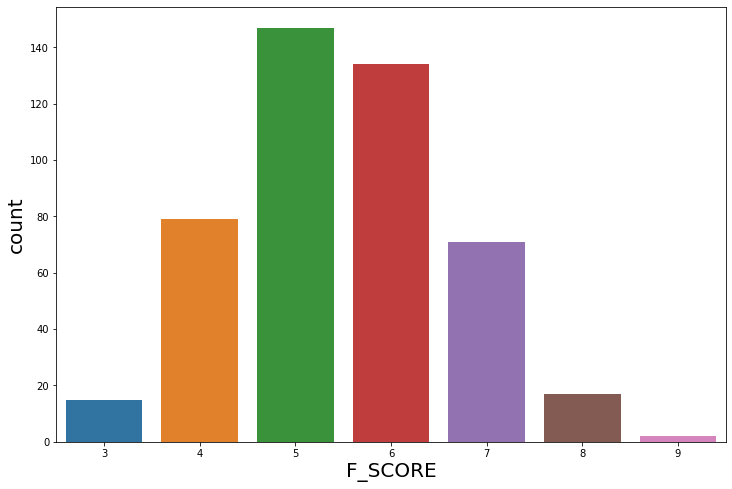

In [541]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='F_SCORE',data=F_Score_df,ax=ax)
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

In [542]:
len(F_Score_df[F_Score_df.F_SCORE==3]), len(F_Score_df[F_Score_df.F_SCORE==8]), len(F_Score_df[F_Score_df.F_SCORE==9])

(15, 17, 2)

### Deciding winners and losers

As we see in this plot, we didn't find any firms with an F-Score of 0 and 1. We can choose the ~2 firms that have the F-Score of 9 along with the 17 firms with the F-Score of 8 for the long positions and the ~15 firms with F-Score of 3 for the short positions.

### Potential Winners (Long Positions)

In [543]:
print(F_Score_df[F_Score_df.F_SCORE==9]['symbol'])
print(F_Score_df[F_Score_df.F_SCORE==8]['symbol'])

286    NGD
326    PVG
Name: symbol, dtype: object
2       AAWW
33      ATNI
36       AUY
61       BTG
62       BTI
70       CBD
83       CLW
91      CNSL
118      DHT
120     DISH
149     EURN
248      LPG
256      MBT
278      NAT
329    QRTEA
330    QRTEB
377     STNG
Name: symbol, dtype: object


### Potential Losers (Short Positions)

In [544]:
print(F_Score_df[F_Score_df.F_SCORE==3]['symbol'])

43      BDL
45     BEDU
75     CECE
86     CMTL
164    FONR
205     HUN
212     IMO
216     IVC
219     JOB
246     LND
250     LRN
268     MOV
281      NC
297    NTWK
312     PHX
Name: symbol, dtype: object
